In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import imageio
from skimage import transform,io
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlub-learning-to-count/train.txt
/kaggle/input/mlub-learning-to-count/test/test/test_composite000000426.png
/kaggle/input/mlub-learning-to-count/train/train/train_composite000012068.png


In [2]:
df_train = pd.read_csv('/kaggle/input/mlub-learning-to-count/train.txt',sep=' ',header=None)
print(df_train.shape)
# take only the first 4000 images
#df_train = df_train.head(4000)

(15000, 2)


### Data augmentation

Per a augmentar la mida del nostre dataset, hem utilitzat un procediment anomenat Data Augmentation per a generar noves dades del conjunt que disposem.

En el meu cas, he decidit fer rotacions de les imatges del dataframe. Encara que podem canviar la il·luminació, contrast, etc.

D'aquesta manera, tenim un model que pot arribar a generalitzar millor gràcies a la varietat d'imatges sintètiques generades.

In [3]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import random
def data_augmentation(img, label, n_generated):
    datagen = ImageDataGenerator(rotation_range=90)
    data_augmentation = []
    data = img_to_array(img)
    samples = expand_dims(data, 0)
    it = datagen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(n_generated):
        # generate batch of images
        batch = it.next()
        image = batch[0].astype('float64')
        image = image[:,:,0]
        data_augmentation.append((image, label))

    listX = [x[0] for x in data_augmentation]
    listy = [x[1] for x in data_augmentation]
    return listX, listy

In [4]:
data_dir = '/kaggle/input/mlub-learning-to-count/train/'
im_size = 64
X_aug = []
y_aug = []
generated_images = 1
for ind, item in df_train.iterrows():
    im  = imageio.imread(data_dir + item[0])/255.
    listx, listy = data_augmentation(im, item[1], generated_images)
    for im in range(len(listx)):
        small_im = transform.resize(listx[im], (im_size,im_size), mode='symmetric', preserve_range=True)
        X_aug.append(small_im)
        y_aug.append(listy[im])
    
    

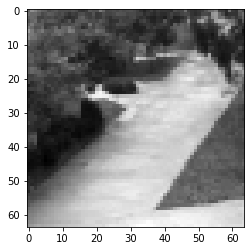

In [5]:
# read images and store into a np array

im_size = 64
N = df_train.shape[0]
X = np.zeros((N, im_size,im_size))
y = np.zeros((N))
cont =0

for ind, item in df_train.iterrows():
    im       = imageio.imread(data_dir + item[0])/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X[cont, :,:] = small_im
    y[cont] = item[1]
    cont+=1

plt.imshow(small_im,cmap='gray')
plt.show()

In [6]:
X = np.concatenate((X, X_aug))
y = np.concatenate((y, y_aug))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.3, random_state=66)

In [8]:
from sklearn.ensemble import RandomForestRegressor
# random forest model 
'''rfc = RandomForestRegressor()
rfc.fit(X_train.reshape((X_train.shape[0],-1)),y_train)
# predictions
rfc_predict = rfc.predict(X_val.reshape((X_val.shape[0],-1)))
'''

'rfc = RandomForestRegressor()\nrfc.fit(X_train.reshape((X_train.shape[0],-1)),y_train)\n# predictions\nrfc_predict = rfc.predict(X_val.reshape((X_val.shape[0],-1)))\n'

In [9]:
from sklearn.metrics import mean_squared_error
'''plt.plot(rfc_predict,y_val,'.')

print(np.sqrt(mean_squared_error(rfc_predict,y_val)))'''

"plt.plot(rfc_predict,y_val,'.')\n\nprint(np.sqrt(mean_squared_error(rfc_predict,y_val)))"

In [10]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
history = {}

In [11]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

### Convolutional Neural Network

Per al nostre model utilitzarem una CNN, perquè estem tractant amb imatges i aquest tipus de NN s'adapta millor a l'anàlisi d'imatges i les seves principals característiques.

In [12]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=5, input_shape=[64, 64, 1], kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=64, kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=64, kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=96, kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation='linear',kernel_regularizer=keras.regularizers.l2(0.001))
])

In [13]:
model.layers

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

In [15]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
callback = keras.callbacks.LearningRateScheduler(lr_schedule)
model.compile(loss="mse",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_val, y_val),verbose=1, batch_size=128, callbacks = [callback])

Learning rate:  0.001
Epoch 1/200
165/165 [==============================] - 4s 25ms/step - loss: 186.5852 - accuracy: 0.0342 - val_loss: 729.5668 - val_accuracy: 0.0332
Learning rate:  0.001
Epoch 2/200
165/165 [==============================] - 4s 22ms/step - loss: 71.2320 - accuracy: 0.0342 - val_loss: 520.5820 - val_accuracy: 0.0332
Learning rate:  0.001
Epoch 3/200
165/165 [==============================] - 3s 21ms/step - loss: 15.3423 - accuracy: 0.0364 - val_loss: 1267.7919 - val_accuracy: 0.0332
Learning rate:  0.001
Epoch 4/200
165/165 [==============================] - 4s 22ms/step - loss: 11.1764 - accuracy: 0.0353 - val_loss: 156.9900 - val_accuracy: 0.0343
Learning rate:  0.001
Epoch 5/200
165/165 [==============================] - 3s 21ms/step - loss: 10.0686 - accuracy: 0.0355 - val_loss: 709.2454 - val_accuracy: 0.0332
Learning rate:  0.001
Epoch 6/200
165/165 [==============================] - 3s 21ms/step - loss: 9.6643 - accuracy: 0.0373 - val_loss: 5.8714 - val_accu

Learning rate:  0.001
Epoch 50/200
165/165 [==============================] - 4s 22ms/step - loss: 5.4224 - accuracy: 0.0401 - val_loss: 48.0344 - val_accuracy: 0.0332
Learning rate:  0.001
Epoch 51/200
165/165 [==============================] - 3s 21ms/step - loss: 5.3857 - accuracy: 0.0391 - val_loss: 31.9575 - val_accuracy: 0.0336
Learning rate:  0.001
Epoch 52/200
165/165 [==============================] - 3s 21ms/step - loss: 5.4393 - accuracy: 0.0373 - val_loss: 17.7121 - val_accuracy: 0.0380
Learning rate:  0.001
Epoch 53/200
165/165 [==============================] - 4s 21ms/step - loss: 5.3672 - accuracy: 0.0388 - val_loss: 92.3123 - val_accuracy: 0.0343
Learning rate:  0.001
Epoch 54/200
165/165 [==============================] - 3s 21ms/step - loss: 5.2536 - accuracy: 0.0381 - val_loss: 22.3552 - val_accuracy: 0.0333
Learning rate:  0.001
Epoch 55/200
165/165 [==============================] - 3s 21ms/step - loss: 5.2791 - accuracy: 0.0366 - val_loss: 21.4049 - val_accuracy:

Learning rate:  0.0001
Epoch 99/200
165/165 [==============================] - 4s 22ms/step - loss: 3.8325 - accuracy: 0.0390 - val_loss: 4.0388 - val_accuracy: 0.0344
Learning rate:  0.0001
Epoch 100/200
165/165 [==============================] - 4s 21ms/step - loss: 3.9103 - accuracy: 0.0410 - val_loss: 2.8456 - val_accuracy: 0.0358
Learning rate:  0.0001
Epoch 101/200
165/165 [==============================] - 4s 21ms/step - loss: 4.0038 - accuracy: 0.0388 - val_loss: 7.5697 - val_accuracy: 0.0343
Learning rate:  0.0001
Epoch 102/200
165/165 [==============================] - 3s 21ms/step - loss: 3.7955 - accuracy: 0.0392 - val_loss: 2.9493 - val_accuracy: 0.0532
Learning rate:  0.0001
Epoch 103/200
165/165 [==============================] - 4s 21ms/step - loss: 3.8237 - accuracy: 0.0394 - val_loss: 7.7189 - val_accuracy: 0.0344
Learning rate:  0.0001
Epoch 104/200
165/165 [==============================] - 3s 21ms/step - loss: 3.7403 - accuracy: 0.0401 - val_loss: 2.5591 - val_accu

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

In [ ]:
import math
y_model1 = model.predict(X_val)
print(y_val)
y_model_output = []
for i in y_model1:
    y_model_output.append(int(round(i[0])))
plt.plot(y_model_output,y_val,'.')
print(y_model_output)
np.sqrt(mean_squared_error(y_model_output,y_val))

In [ ]:
## evaluate test and generate submission
test_dir = '/kaggle/input/mlub-learning-to-count/test/test/'
im_size = 64
N = 500
X_test = np.zeros((N, im_size,im_size))
cont =0

for x in range(500):
    im       = imageio.imread(test_dir + 'test_composite'+str(x).zfill(9) + '.png')/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X_test[cont, :,:] = small_im
    cont+=1
    
plt.imshow(small_im)
plt.show()

In [ ]:
X_test = X_test[..., np.newaxis]

In [ ]:
# create the file to make the sumbission

y_test = model.predict(X_test)
print(y_test)
y_test = [int(round(x[0])) for x in y_test]

df_output = pd.DataFrame(y_test)
df_output.index.name = 'index'
df_output.columns = ['prediction']
df_output.to_csv('output.csv')


In [ ]:
print(y_test)

### El model

#### Capes principals

El model utilitzat consta d'una CNN, com ja s'ha mencionat anteriorment, una xarxa neuronal convolucional té una major capacitat d'obtenir les característiques principals d'una imatge gràcies a les capes de convolució i de Max Pool entre d'altres.

Si parlem del model utilitzat, aquest consta d'una primera part composada per vàries capes de convolució. Els filtres de les capes convolucionals són bastant similars, he decidit fer la xarxa profunda enlloc d'ample. Podem veure en varis papers que les CNN amples són bones en la memorització, cosa que no ens interessa si volem generalitzar el màxim possible.
El fet que sigui profunda, ens ajuda a generalitzar i que la CNN aprengui més característiques del problema.
Si parlem del kernel i padding, aquests han estat estàtics, no els he canviat, 3 i SAME m'ahn funcionat bé. La funció d'activació que utilitzo és la ReLU, aquesta acostuma a ser més eficient (no calcula funcions polinòmiques, bàsicament escull entre dos nombres) i ajuda a que el gradient no desapareixi (vanish).
Seguides de les capes convolucionals, tenim capes de Max Pooling. Les utilitzo per obtenir la màxima resposta després de fer la convolució, no n'he utilitzat més de dues ja que la mida de la imatge no és gaire gran (64x64).

La segona part del model es composa per capes Dense o Fully connected (No lineals) que utilitzen la funció d'activació ReLU. Aquest conjunt esta totalment conectat i ens permet passar d'una dimensió 2D (com són les nostres imatges) a un vector.

Per últim, la capa de sortida és una capa Dense també, però utilitza una funció d'activació linear amb una sola sortida que ens donarà un nombre decimal.
Podriem pensar que aquest problema es tracta d'una classificació, i així el vaig enfocar inicialment, però en realitat el que volem és que la nostra xarxa convolucional pugui comptar quantes persones hi han a la imatge sense cap mena de limitació, cosa que la fa més interessant.
Com que ens surten valors decimals, el que fem és arrodonir-los al nombre més pròxim i fer conversió a enter.

#### Overfitting

- Per a evitar overfitting he utilitzat les capes Dropout (gairebé després de totes les capes del model) amb un percentatge com a argument, aquesta és una de les formes més senzilles de reduir l'overfitting. Aquestes capes eliminen de forma aleatòria neurones de la xarxa.

- Una altra tècnica utilitzada (en la majoria de capes) és el keras.regularizer. Aquest es basa en la regulació dels pesos de les neurones per a evitar l'overfitting. En el cas del model utilitzat, m'he centrat en el l2, ja que m'ha funcionat millor que l1. Per a ajustar bé el valor de l2 també he hagut d'adaptar-lo bé al meu model per a un bon funcionament, amb 1E-3 ha funcionat força bé.

#### Learning rate

El learning rate és la quantitat de pesos que s'actualitzen a la xarxa mentres dura l'entrenament. Es considera una bona pràctica fer decaure aquest hiperparàmetre a mesura que avancen les epochs. 

Ajustar aquest aspecte ajuda al model a que entreni de forma òptima.

#### Tècniques per a millorar el rendiment

Un aspecte a destacar és el data augmentation. Aquesta tècnica ens permet crear imatges noves i els canvis que volem que presenten, rotacions majoritàriament, ajuden al model a generalitzar i a classificar millor en diferents condicions. En el meu cas he utilitzat al voltant d'1 i 4 imatges sintètiques per cada imatge del dataset d'entrenament, d'aquesta manera tenim les fotografies originals i les rotades.

Per a utilitzar eficientment el temps d'execució i que l'entrenament no trigui molta estona, m'he fixat en el loss i el validation loss. Aquest quan no canvia, és a dir, esta comprès en un interval de valors molt petit, l'entrenament pot acabar perfectament.


### Conclusions finals

Considero que el model creat fa la seva funció prou bé, encara que sempre és millorable. He sigut curós en no caure en l'overfitting, pendent de la loss i loss del conjunt de validació, crec que és un hàbit que em serà molt útil en el futur.

He après el funcionament i objectiu de les CNNs i com poder adaptar-les a un conjunt de dades donat juntament amb els hiperparàmetres corresponents, com el learning rate i l'optimitzador adequat entre d'altres.


